# **Composer classification Model**
___

#### **Problem Statement**

We are going to be working with the MIDI files of classical music composers. We will be using the MIDI files to classify the composer of the music. We will be using the MIDI files of the following composers: Bach Beethoven, chopin and Mozart. We will be building a CNN network to classify the composers, and we will also be making functions that will make the process of dealing with the midi files easier to work with. The objective is to get the classification model to be at approximately 90% accuracy, or better. 

In [359]:
# standard libraries for data manipulation, visualisation, and deep learning
import os
import time
import pretty_midi
import numpy as np
import polars as pl
import pandas as pd
from mido import KeySignatureError
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt
import seaborn as sns


# machine and deep learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.cuda.amp as amp

In [360]:
# midi file path and the composers in the file path
main_dir = 'midiclassics'
composers = ['Chopin', 'Beethoven', 'Bach', 'Mozart']

In [361]:
# function to calculate notes density
def calculate_notes_density(midi_data, max_sequence_length=300):
    total_notes = sum(len(instr.notes) for instr in midi_data.instruments)
    duration = midi_data.get_end_time()
    density = total_notes / duration
    return density

In [362]:
# function to get chroma features
def get_chroma(midi_data, fs=100):
    chroma = midi_data.get_chroma(fs=fs)
    return chroma

In [363]:
# function to calculate rhythmic features
def calculate_rhythmic_features(midi_data):
    inter_onset_intervals = []
    onsets = sorted(note.start for instr in midi_data.instruments for note in instr.notes)
    for i in range(1, len(onsets)):
        inter_onset_intervals.append(onsets[i] - onsets[i-1])
    
    rhythmic_density = len(onsets) / midi_data.get_end_time() if midi_data.get_end_time() > 0 else 0
    mean_ioi = np.mean(inter_onset_intervals) if inter_onset_intervals else 0
    var_ioi = np.var(inter_onset_intervals) if inter_onset_intervals else 0
    
    return mean_ioi, var_ioi, rhythmic_density

In [364]:
# velocity histogram
def calculate_velocity_histogram(midi_data):
    velocities = [note.velocity for instr in midi_data.instruments for note in instr.notes]
    histogram, _ = np.histogram(velocities, bins=range(0, 128, 10), density=True)
    return histogram

In [365]:
# function to extract features from the midi files, will need to change when adding more features to model
def extract_features(midi_file, max_sequence_length=300):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_file)
    except KeySignatureError as e:
        print(f"Failed to process {midi_file} due to key signature error: {e}")
        return None, None
    except Exception as e:
        print(f"Failed to process {midi_file} due to error: {e}")
        return None, None

    features = {}

    # tempo
    features['tempo'] = midi_data.estimate_tempo()

    # handling key signatures errors that happen with some midi files 
    try:
        features['key_signatures'] = [key.key_number for key in midi_data.key_signature_changes]
    except KeySignatureError as e:
        print(f"Key signature error in file {midi_file}: {e}")
        features['key_signatures'] = [0]  # Default to C major/A minor if error occurs
    except Exception as e:
        print(f"General error in file {midi_file}: {e}")
        features['key_signatures'] = [0]

    # getting the time signatures
    features['time_signatures'] = [(time.numerator, time.denominator) for time in midi_data.time_signature_changes]

    # instrument types
    features['instrument_types'] = [instr.program for instr in midi_data.instruments]

    # notes hist 
    histogram = np.zeros(12)
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            pitch_class = note.pitch % 12
            histogram[pitch_class] += 1
    if np.sum(histogram) > 0:
        histogram /= np.sum(histogram)
    features['notes_histogram'] = histogram

    # notes matrix
    notes = np.zeros((max_sequence_length, 128))
    end_time = midi_data.get_end_time()
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            start = int(note.start * max_sequence_length / end_time)
            end = int(note.end * max_sequence_length / end_time)
            notes[start:end, note.pitch] = note.velocity / 127
    features['notes_matrix'] = notes

    # Chroma features
    features['chroma'] = get_chroma(midi_data)

    # Notes density
    features['notes_density'] = calculate_notes_density(midi_data)
    
    # Note onsets
    onsets = [note.start for instr in midi_data.instruments for note in instr.notes]
    features['note_onsets'] = len(onsets) / end_time if end_time > 0 else 0

    # Polyphony
    times = np.arange(0, end_time, 0.1)
    polyphony = [sum(1 for note in instr.notes if note.start <= t <= note.end) for instr in midi_data.instruments for t in times]
    features['polyphony'] = np.mean(polyphony)

    # Note durations
    durations = [note.end - note.start for instr in midi_data.instruments for note in instr.notes]
    features['note_duration_mean'] = np.mean(durations)
    features['note_duration_variance'] = np.var(durations)

    # Velocity
    velocities = [note.velocity for instr in midi_data.instruments for note in instr.notes]
    features['velocity_mean'] = np.mean(velocities)
    features['velocity_variance'] = np.var(velocities)

    # Pitch bend
    pitch_bends = [bend.pitch for instr in midi_data.instruments for bend in instr.pitch_bends]
    features['pitch_bend_mean'] = np.mean(pitch_bends) if pitch_bends else 0
    features['pitch_bend_variance'] = np.var(pitch_bends) if pitch_bends else 0

    # Rhythmic features
    mean_ioi, var_ioi, rhythmic_density = calculate_rhythmic_features(midi_data)
    features['mean_ioi'] = mean_ioi
    features['var_ioi'] = var_ioi
    features['rhythmic_density'] = rhythmic_density

    # Velocity histogram
    features['velocity_histogram'] = calculate_velocity_histogram(midi_data)

    return features, os.path.basename(midi_file)

In [231]:
def process_composer(composer):
    composer_folder = os.path.join(main_dir, composer)
    composer_data = []
    composer_labels = []
    for file in os.listdir(composer_folder):
        if file.endswith('.midi') or file.endswith('.mid') or file.endswith('.MID'):
            file_path = os.path.join(composer_folder, file)
            start_time = time.time()
            try:
                features, filename = extract_features(file_path)
                end_time = time.time()
                if features is not None:
                    processing_time = end_time - start_time
                    print(f"Processed {filename} by {composer} in {processing_time:.2f} seconds")
                    composer_data.append(features)
                    composer_labels.append(composer)
                else:
                    print(f"Skipping file {file_path} by {composer} due to extraction error.")
            except Exception as e:
                print(f"Failed to process {file_path} by {composer}: {e}")
    return composer_data, composer_labels


In [366]:
# pulling out just one file's data to see what the features look like and print the labels to a test data frame

composer = 'Chopin'
composer_folder = os.path.join(main_dir, composer)
file = os.listdir(composer_folder)[0]
file_path = os.path.join(composer_folder, file)
features, _ = extract_features(file_path)

print(features.keys())
print(features['tempo'])
print(features['key_signatures'])
print(features['time_signatures'])
print(features['instrument_types'])
print(features['notes_histogram'])
print(features['notes_matrix'])
print(features['chroma'])
print(features['notes_density'])
print(features['note_onsets'])
print(features['polyphony'])
print(features['note_duration_mean'])
print(features['note_duration_variance'])
print(features['velocity_mean'])
print(features['velocity_variance'])
print(features['pitch_bend_mean'])
print(features['pitch_bend_variance'])
print(features['mean_ioi'])
print(features['var_ioi'])
print(features['rhythmic_density'])
print(features['velocity_histogram'])

# creating a test data frame to see the labels
test_data = pd.DataFrame()
test_data['composer'] = composers
test_data['label'] = LabelEncoder().fit_transform(composers)
test_data


dict_keys(['tempo', 'key_signatures', 'time_signatures', 'instrument_types', 'notes_histogram', 'notes_matrix', 'chroma', 'notes_density', 'note_onsets', 'polyphony', 'note_duration_mean', 'note_duration_variance', 'velocity_mean', 'velocity_variance', 'pitch_bend_mean', 'pitch_bend_variance', 'mean_ioi', 'var_ioi', 'rhythmic_density', 'velocity_histogram'])
180.0852133684428
[22]
[(6, 4), (4, 4)]
[0]
[0.1059216  0.12427023 0.02668891 0.14345288 0.0558799  0.15679733
 0.10341952 0.02001668 0.05838198 0.0675563  0.11592994 0.02168474]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...  96.  96.  96.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [ 80.  80.  80. ...   0.   0.   0.]
 [  0.   0.   0. ... 384. 384. 384.]
 [  0.   0.   0. ...   0.   0.   0.]]
18.734393734393734
18.734393734393734
3.2078125
0.17216641196602636
0.026548

,composer,label
0,Chopin,2
1,Beethoven,1
2,Bach,0
3,Mozart,3


In [367]:
# running the full thing to extract all the data from the midi files from all the composers
if __name__ == "__main__":
    data = []
    labels = []

    # process each composer sequentially
    for composer in composers:
        composer_data, composer_labels = process_composer(composer)
        data.extend(composer_data)
        labels.extend(composer_labels)

    print("Data extraction has been completed.")

Processed (2542)Prelude opus.28, No.16 in B flat minor.mid by Chopin in 0.09 seconds
Processed 19 Polish Songs, for Solo Voice and Piano accomplements, No.10.mid by Chopin in 0.17 seconds
Processed 19 Polish Songs, for Solo Voice and Piano accomplements, No.11.mid by Chopin in 0.05 seconds


c:\Users\tehwh\anaconda3\envs\ml\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Processed 19 Polish Songs, for Solo Voice and Piano accomplements, No.12.mid by Chopin in 0.15 seconds
Processed 19 Polish Songs, for Solo Voice and Piano accomplements, No.13.mid by Chopin in 0.19 seconds
Processed 19 Polish Songs, for Solo Voice and Piano accomplements, No.14.mid by Chopin in 0.08 seconds
Processed 19 Polish Songs, for Solo Voice and Piano accomplements, No.15.mid by Chopin in 0.17 seconds
Processed 19 Polish Songs, for Solo Voice and Piano accomplements, No.16.mid by Chopin in 0.15 seconds
Processed 19 Polish Songs, for Solo Voice and Piano accomplements, No.17.mid by Chopin in 0.30 seconds
Processed 19 Polish Songs, for Solo Voice and Piano accomplements, No.18.mid by Chopin in 0.22 seconds
Processed 19 Polish Songs, for Solo Voice and Piano accomplements, No.19.mid by Chopin in 0.02 seconds
Processed 19 Polish Songs, for Solo Voice and Piano accomplements, No.2.mid by Chopin in 0.10 seconds
Processed 19 Polish Songs, for Solo Voice and Piano accomplements, No.3.mi

c:\Users\tehwh\anaconda3\envs\ml\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Processed Rage over a lost pennny.mid by Beethoven in 1.52 seconds
Processed Romance piano.mid by Beethoven in 1.10 seconds
Processed Rondo in B flat.mid by Beethoven in 0.90 seconds
Processed Rondo Opus.51, No.1.mid by Beethoven in 0.42 seconds
Processed Rondo Opus.51, No.2.mid by Beethoven in 0.81 seconds
Processed Sechs Variationen.mid by Beethoven in 0.44 seconds
Processed Seven Inversions of God Save the King.mid by Beethoven in 1.15 seconds
Processed Sieben Bagatellen, C Major, Opus.33, No.2.mid by Beethoven in 0.26 seconds
Processed Sieben Bagatellen, in A Major, Opus.33, No.4.mid by Beethoven in 0.12 seconds
Processed Sieben Bagatellen, in C Major, Opus.33, No.5.mid by Beethoven in 0.25 seconds
Processed Sieben Bagatellen, in D Major, Opus.33, No.6.mid by Beethoven in 0.12 seconds
Processed Sieben Bagatellen, in E flat Major, Opus.33, No.1.mid by Beethoven in 0.25 seconds
Processed Sieben Bagatellen, in F Major, Opus.33, No.3.mid by Beethoven in 0.09 seconds
Processed Sketch fo

In [368]:
def preprocess_features(df):
    # flatten the complex features
    df['key_signatures'] = df['key_signatures'].apply(lambda x: x[:1] if len(x) > 0 else [0])  # Use first key signature
    df['instrument_types'] = df['instrument_types'].apply(lambda x: x[:1] if len(x) > 0 else [0])  # Use first instrument type
    df['notes_histogram'] = df['notes_histogram'].apply(lambda x: x[:12] if len(x) >= 12 else np.zeros(12))  # Ensure length 12
    
    # Ensure consistent size for 'notes_matrix' and 'chroma'
    max_sequence_length = 300
    df['notes_matrix'] = df['notes_matrix'].apply(lambda x: x.flatten() if x.size == max_sequence_length * 128 else np.pad(x.flatten(), (0, max_sequence_length * 128 - x.size), 'constant'))
    
    # concat into a single array
    feature_array = np.hstack([
        df['tempo'].values.reshape(-1, 1),
        np.vstack(df['key_signatures']),
        np.vstack(df['instrument_types']),
        np.vstack(df['notes_histogram']),
        np.vstack(df['notes_matrix']),
        df['notes_density'].values.reshape(-1, 1),
        df['note_onsets'].values.reshape(-1, 1),
        df['polyphony'].values.reshape(-1, 1),
        df['note_duration_mean'].values.reshape(-1, 1),
        df['note_duration_variance'].values.reshape(-1, 1),
        df['velocity_mean'].values.reshape(-1, 1),
        df['velocity_variance'].values.reshape(-1, 1),
        df['pitch_bend_mean'].values.reshape(-1, 1),
        df['pitch_bend_variance'].values.reshape(-1, 1),
    ])
    
    return feature_array

In [369]:
# converting the data to a pandas dataframe and the labels to a numpy array
data_pl = pl.DataFrame(data)
data_df = data_pl.to_pandas()
labels = np.array(labels)

In [370]:
# mending the data to matching composer labels 
feature_array = preprocess_features(data_df)
label_encoder = LabelEncoder()
label_array = label_encoder.fit_transform(labels)

# verifying the composer labels are with the matching data
print(feature_array.shape)
print(label_array.shape)

(1627, 38424)
(1627,)


In [371]:
# printing the features from the first file and the matching composer label to verify the data is correct
print(feature_array[0])
print(label_array[0])

[180.08521337  22.           0.         ...  48.00032276   0.
   0.        ]
2


In [372]:
# checking the columns of the df 
data_df.columns

Index(['tempo', 'key_signatures', 'time_signatures', 'instrument_types',
       'notes_histogram', 'notes_matrix', 'chroma', 'notes_density',
       'note_onsets', 'polyphony', 'note_duration_mean',
       'note_duration_variance', 'velocity_mean', 'velocity_variance',
       'pitch_bend_mean', 'pitch_bend_variance', 'mean_ioi', 'var_ioi',
       'rhythmic_density', 'velocity_histogram'],
      dtype='object')

In [378]:
# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [379]:
# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(preprocess_features(data_df))

In [380]:
# pre processing the data for the model
features = preprocess_features(data_df)
# ecoding the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
# standardizing the features 
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
# reshaping the features 
scaled_features = scaled_features.reshape(scaled_features.shape[0], 1, scaled_features.shape[1])

In [381]:
# setting the batch size
batch_size = 32

# splitting the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(scaled_features, encoded_labels, test_size=0.2, random_state=42)

# Model Architecture

In [382]:
# define the model
class CNNLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(CNNLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm = nn.LSTM(64, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.permute(0, 2, 1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [383]:
# printing the model architecture
model_arch = CNNLSTMClassifier(input_size=feature_array.shape[1], hidden_size=128, num_layers=2, num_classes=len(composers))
print(model_arch)

CNNLSTMClassifier(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)


In [384]:
# create a dataset and dataloader
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

In [385]:
# data loaders to device
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True, num_workers=3)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False, num_workers=2)

In [386]:
# hyperparameters
input_size = X_train_tensor.shape[2]
hidden_size = 128
num_layers = 2
num_classes = len(np.unique(y_train))
num_epochs = 20
learning_rate = 0.001
patience = 5

In [387]:
# checking cuda 
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

True
1
NVIDIA GeForce RTX 2060
Using device: cuda


In [388]:
# Early stopping parameters
best_val_loss = float('inf')
epochs_no_improve = 2

In [389]:
# Initialize the model, loss function, and optimizer
model = CNNLSTMClassifier(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scaler = torch.cuda.amp.GradScaler()

C:\Users\tehwh\AppData\Local\Temp\ipykernel_6888\962088949.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [390]:
# Early stopping parameters
best_loss = float('inf')
epochs_no_improve = 0

In [391]:
# Training the model with mixed precision
model.train()
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    running_loss = 0.0
    
    for i, (X_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        with torch.cuda.amp.autocast():
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        
        # Print the loss for batches
        print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    avg_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')
    
    # Time calculations
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f'Epoch [{epoch+1}/{num_epochs}] Duration: {epoch_duration:.2f} seconds')
    
    # early stoping
    if avg_loss < best_loss:
        best_loss = avg_loss
        epochs_no_improve = 0
        # save model 
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping!")
            break


C:\Users\tehwh\AppData\Local\Temp\ipykernel_6888\868758547.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/20], Batch [1/41], Loss: 1.3482
Epoch [1/20], Batch [2/41], Loss: 1.3443
Epoch [1/20], Batch [3/41], Loss: 1.3201
Epoch [1/20], Batch [4/41], Loss: 1.2457
Epoch [1/20], Batch [5/41], Loss: 1.2415
Epoch [1/20], Batch [6/41], Loss: 1.2273
Epoch [1/20], Batch [7/41], Loss: 1.1832
Epoch [1/20], Batch [8/41], Loss: 1.3144
Epoch [1/20], Batch [9/41], Loss: 0.9650
Epoch [1/20], Batch [10/41], Loss: 1.1017
Epoch [1/20], Batch [11/41], Loss: 1.3106
Epoch [1/20], Batch [12/41], Loss: 0.9817
Epoch [1/20], Batch [13/41], Loss: 1.0017
Epoch [1/20], Batch [14/41], Loss: 0.7289
Epoch [1/20], Batch [15/41], Loss: 0.7615
Epoch [1/20], Batch [16/41], Loss: 1.0346
Epoch [1/20], Batch [17/41], Loss: 1.1597
Epoch [1/20], Batch [18/41], Loss: 1.0118
Epoch [1/20], Batch [19/41], Loss: 1.0162
Epoch [1/20], Batch [20/41], Loss: 0.9985
Epoch [1/20], Batch [21/41], Loss: 1.0477
Epoch [1/20], Batch [22/41], Loss: 0.9435
Epoch [1/20], Batch [23/41], Loss: 1.1380
Epoch [1/20], Batch [24/41], Loss: 1.3017
E

In [392]:
# model evaluation
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(val_loader):
        start_time = time.time()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total_test += y_batch.size(0)
        correct_test += (predicted == y_batch).sum().item()
        end_time = time.time()
        batch_time = end_time - start_time
        # print progress
        print(f'Batch [{i+1}/{len(val_loader)}] processed in {batch_time:.2f} seconds')
        
accuracy_test = 100 * correct_test / total_test
print(f'Test Accuracy: {accuracy_test:.2f}%')

Batch [1/11] processed in 12.42 seconds
Batch [2/11] processed in 11.26 seconds
Batch [3/11] processed in 10.24 seconds
Batch [4/11] processed in 11.31 seconds
Batch [5/11] processed in 11.15 seconds
Batch [6/11] processed in 10.73 seconds
Batch [7/11] processed in 10.10 seconds
Batch [8/11] processed in 10.40 seconds
Batch [9/11] processed in 10.92 seconds
Batch [10/11] processed in 10.91 seconds
Batch [11/11] processed in 1.66 seconds
Test Accuracy: 79.75%


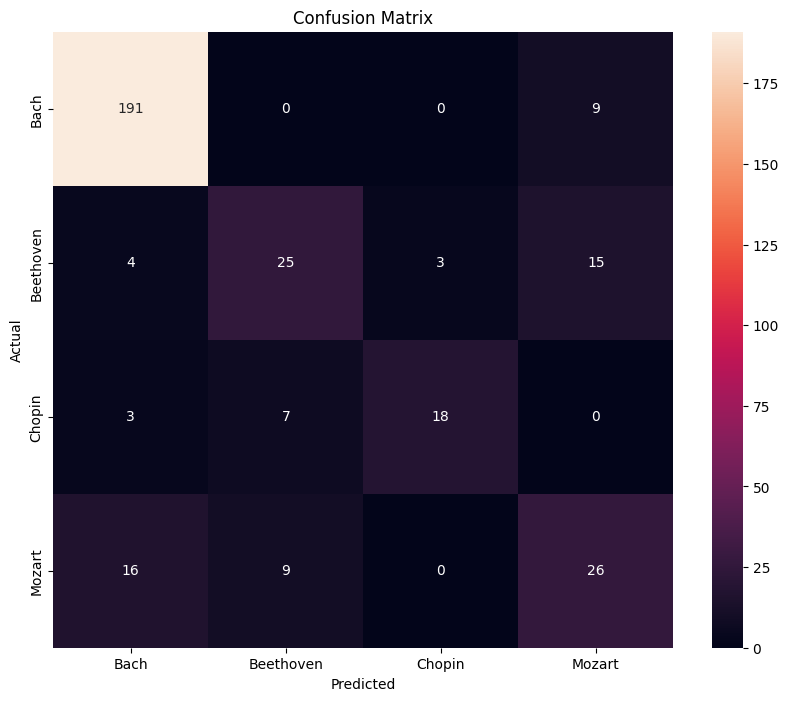

In [393]:
# plotting the confusion matrix
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(val_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())
        
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [394]:
# F1 score, precision, recall, and accuracy on the model 
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

# printing the metrics
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')

F1 Score: 0.7916
Precision: 0.7904
Recall: 0.7975
Accuracy: 0.7975


In [395]:
# classification report
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

        Bach       0.89      0.95      0.92       200
   Beethoven       0.61      0.53      0.57        47
      Chopin       0.86      0.64      0.73        28
      Mozart       0.52      0.51      0.51        51

    accuracy                           0.80       326
   macro avg       0.72      0.66      0.69       326
weighted avg       0.79      0.80      0.79       326



In [396]:
# saving the model down to a .pt file for now 
torch.save(model.state_dict(), '2_conv_1_lstm_model.pt')

### Model Architecture Changes
- **One more additional CNN layer**: this will hopefully have the model to learn more complex patterns in the data.

In [403]:
# makinhg the model more complex by adding more two more convolutional layers

class BiggerCNNLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiggerCNNLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm = nn.LSTM(128, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.permute(0, 2, 1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [404]:
# hyperparameters
input_size = X_train_tensor.shape[2]
hidden_size = 128
num_layers = 2
num_classes = len(np.unique(y_train))
num_epochs = 20
learning_rate = 0.001
patience = 5

In [406]:
# moving the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiggerCNNLSTMClassifier(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scaler = torch.cuda.amp.GradScaler()

C:\Users\tehwh\AppData\Local\Temp\ipykernel_6888\3641297307.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [407]:
# print the model architecture of the bigger model
print(model)

BiggerCNNLSTMClassifier(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)


In [408]:
# training the bigger model on the same data 

model.train()
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    running_loss = 0.0
    
    for i, (X_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        with torch.cuda.amp.autocast():
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        
        # Print the loss for batches
        print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    avg_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')
    
    # Time calculations
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f'Epoch [{epoch+1}/{num_epochs}] Duration: {epoch_duration:.2f} seconds')
    
    # early stoping
    if avg_loss < best_loss:
        best_loss = avg_loss
        epochs_no_improve = 0
        # save model 
        torch.save(model.state_dict(), 'bigger_best_model.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping!")
            break

C:\Users\tehwh\AppData\Local\Temp\ipykernel_6888\622571402.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/20], Batch [1/41], Loss: 1.3834
Epoch [1/20], Batch [2/41], Loss: 1.3720
Epoch [1/20], Batch [3/41], Loss: 1.3510
Epoch [1/20], Batch [4/41], Loss: 1.3275
Epoch [1/20], Batch [5/41], Loss: 1.3033
Epoch [1/20], Batch [6/41], Loss: 1.2531
Epoch [1/20], Batch [7/41], Loss: 1.1837
Epoch [1/20], Batch [8/41], Loss: 1.1564
Epoch [1/20], Batch [9/41], Loss: 0.9940
Epoch [1/20], Batch [10/41], Loss: 1.1672
Epoch [1/20], Batch [11/41], Loss: 1.2849
Epoch [1/20], Batch [12/41], Loss: 1.1320
Epoch [1/20], Batch [13/41], Loss: 1.0372
Epoch [1/20], Batch [14/41], Loss: 1.0169
Epoch [1/20], Batch [15/41], Loss: 0.9754
Epoch [1/20], Batch [16/41], Loss: 1.0304
Epoch [1/20], Batch [17/41], Loss: 0.9436
Epoch [1/20], Batch [18/41], Loss: 1.0609
Epoch [1/20], Batch [19/41], Loss: 1.0241
Epoch [1/20], Batch [20/41], Loss: 0.8883
Epoch [1/20], Batch [21/41], Loss: 0.9581
Epoch [1/20], Batch [22/41], Loss: 0.9803
Epoch [1/20], Batch [23/41], Loss: 1.0752
Epoch [1/20], Batch [24/41], Loss: 1.1344
E

In [411]:
# evaluting the model with one extra convolutional layer

model.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(val_loader):
        start_time = time.time()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total_test += y_batch.size(0)
        correct_test += (predicted == y_batch).sum().item()
        end_time = time.time()
        batch_time = end_time - start_time
        # print progress
        print(f'Batch [{i+1}/{len(val_loader)}] processed in {batch_time:.2f} seconds')
    accuracy_test_2 = 100 * correct_test / total_test
    print(f'Test Accuracy: {accuracy_test_2:.2f}%')

Batch [1/11] processed in 5.90 seconds
Batch [2/11] processed in 5.50 seconds
Batch [3/11] processed in 5.45 seconds
Batch [4/11] processed in 5.57 seconds
Batch [5/11] processed in 5.57 seconds
Batch [6/11] processed in 5.45 seconds
Batch [7/11] processed in 5.50 seconds
Batch [8/11] processed in 5.56 seconds
Batch [9/11] processed in 5.54 seconds
Batch [10/11] processed in 5.59 seconds
Batch [11/11] processed in 0.80 seconds
Test Accuracy: 71.17%


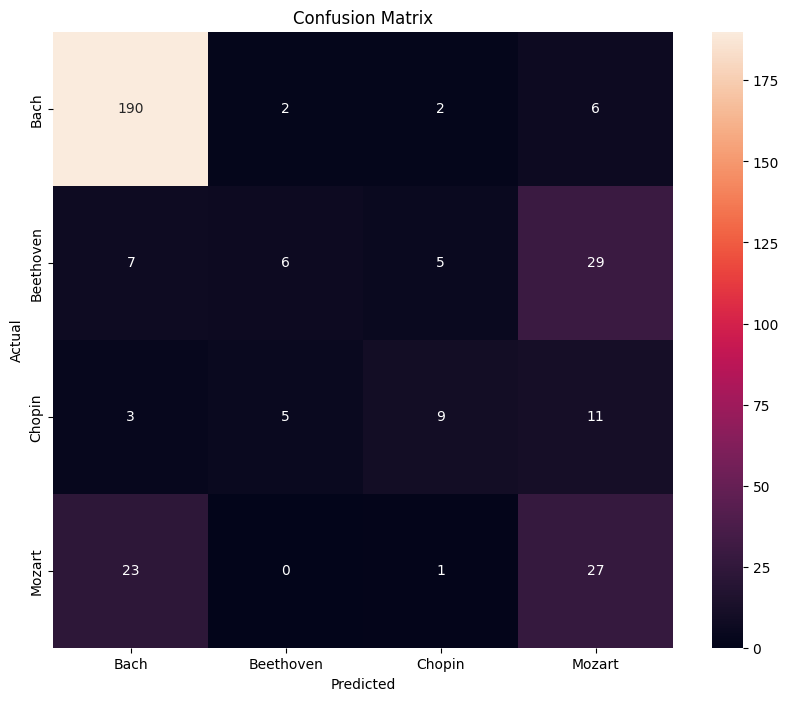

In [412]:
# plotting the confusion matrix for the bigger model
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(val_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())
        
cm_bigger = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_bigger, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [413]:
# printing the classification report for the bigger model
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

        Bach       0.85      0.95      0.90       200
   Beethoven       0.46      0.13      0.20        47
      Chopin       0.53      0.32      0.40        28
      Mozart       0.37      0.53      0.44        51

    accuracy                           0.71       326
   macro avg       0.55      0.48      0.48       326
weighted avg       0.69      0.71      0.68       326



In [414]:
# saving the bigger model to a .pt file
torch.save(model.state_dict(), '3_conv_1_lstm_model.pt')

## Removing the CNN Layer and adding in an additional LSTM layer

In [415]:
# define model 
class BiggerLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiggerLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm1 = nn.LSTM(64, hidden_size, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.permute(0, 2, 1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm1(x, (h0, c0))
        out, _ = self.lstm2(out)
        out = self.fc(out[:, -1, :])
        return out

In [416]:
# same hyperparameters as the previous models
input_size = X_train_tensor.shape[2]
hidden_size = 128
num_layers = 2
num_classes = len(np.unique(y_train))
num_epochs = 20
learning_rate = 0.001
patience = 5

In [417]:
# Moving the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiggerLSTMClassifier(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scaler = torch.cuda.amp.GradScaler()

C:\Users\tehwh\AppData\Local\Temp\ipykernel_6888\2658570981.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [418]:
# print the model architecture to verify
print(model)

BiggerLSTMClassifier(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm1): LSTM(64, 128, num_layers=2, batch_first=True)
  (lstm2): LSTM(128, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)


In [419]:
# training the model
model.train()
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    running_loss = 0.0
    
    for i, (X_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        with torch.cuda.amp.autocast():
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        
        # Print the loss for batches
        print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    avg_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')
    
    # Time calculations
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f'Epoch [{epoch+1}/{num_epochs}] Duration: {epoch_duration:.2f} seconds')
    
    # early stoping
    if avg_loss < best_loss:
        best_loss = avg_loss
        epochs_no_improve = 0
        # save model 
        torch.save(model.state_dict(), 'bigger_best_model.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping!")
            break

C:\Users\tehwh\AppData\Local\Temp\ipykernel_6888\1307441334.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/20], Batch [1/41], Loss: 1.3785
Epoch [1/20], Batch [2/41], Loss: 1.3706
Epoch [1/20], Batch [3/41], Loss: 1.3602
Epoch [1/20], Batch [4/41], Loss: 1.3268
Epoch [1/20], Batch [5/41], Loss: 1.3302
Epoch [1/20], Batch [6/41], Loss: 1.2291
Epoch [1/20], Batch [7/41], Loss: 1.2193
Epoch [1/20], Batch [8/41], Loss: 1.2284
Epoch [1/20], Batch [9/41], Loss: 1.0464
Epoch [1/20], Batch [10/41], Loss: 0.9751
Epoch [1/20], Batch [11/41], Loss: 1.2059
Epoch [1/20], Batch [12/41], Loss: 1.0310
Epoch [1/20], Batch [13/41], Loss: 1.1112
Epoch [1/20], Batch [14/41], Loss: 0.9560
Epoch [1/20], Batch [15/41], Loss: 1.1458
Epoch [1/20], Batch [16/41], Loss: 1.1622
Epoch [1/20], Batch [17/41], Loss: 0.9792
Epoch [1/20], Batch [18/41], Loss: 1.1615
Epoch [1/20], Batch [19/41], Loss: 1.2037
Epoch [1/20], Batch [20/41], Loss: 1.0108
Epoch [1/20], Batch [21/41], Loss: 0.9524
Epoch [1/20], Batch [22/41], Loss: 1.1513
Epoch [1/20], Batch [23/41], Loss: 0.9886
Epoch [1/20], Batch [24/41], Loss: 1.1250
E

In [420]:
print(model)

BiggerLSTMClassifier(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm1): LSTM(64, 128, num_layers=2, batch_first=True)
  (lstm2): LSTM(128, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)


In [422]:
model.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(val_loader):
        start_time = time.time()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total_test += y_batch.size(0)
        correct_test += (predicted == y_batch).sum().item()
        end_time = time.time()
        batch_time = end_time - start_time
        # print progress
        print(f'Batch [{i+1}/{len(val_loader)}] processed in {batch_time:.2f} seconds')
    accuracy_test_3 = 100 * correct_test / total_test
    print(f'Test Accuracy: {accuracy_test_2:.2f}%')

Batch [1/11] processed in 22.18 seconds
Batch [2/11] processed in 21.90 seconds
Batch [3/11] processed in 21.95 seconds
Batch [4/11] processed in 22.38 seconds
Batch [5/11] processed in 22.07 seconds
Batch [6/11] processed in 21.66 seconds
Batch [7/11] processed in 21.77 seconds
Batch [8/11] processed in 21.33 seconds
Batch [9/11] processed in 21.13 seconds
Batch [10/11] processed in 21.78 seconds
Batch [11/11] processed in 3.24 seconds
Test Accuracy: 71.17%


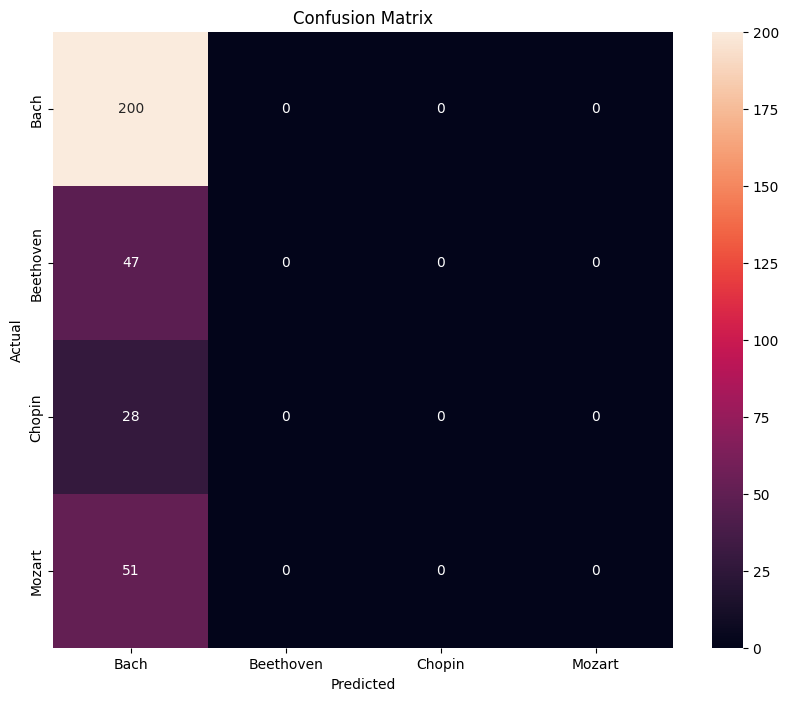

In [423]:
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(val_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())
        
lstm_bigger_cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(lstm_bigger_cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [424]:
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

        Bach       0.61      1.00      0.76       200
   Beethoven       0.00      0.00      0.00        47
      Chopin       0.00      0.00      0.00        28
      Mozart       0.00      0.00      0.00        51

    accuracy                           0.61       326
   macro avg       0.15      0.25      0.19       326
weighted avg       0.38      0.61      0.47       326



c:\Users\tehwh\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tehwh\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tehwh\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### It appears that the model is overfitting, so we will validate the model to ensure that the model is in fact overfitting. If the model is overfitting, we will revert back to the inital model architecture and possibly do some data augmentation to help with the overfitting.

In [425]:
# saving the model to a .pt file
torch.save(model.state_dict(), '2_lstm_model.pt')

## Bringing back the Original Model Architecture, and making some slight changes to the model architecture

In [427]:
# first checking the data to see if it is in the correct format which could be causing the over fitting 

# checking the data shape
print(X_train_tensor.shape)

torch.Size([1301, 1, 38424])


In [428]:
# printing the first tensor of the training data
print(X_train_tensor[0])

# printing the label of the first tensor
print(y_train_tensor[0])

tensor([[ 2.5810, -0.8281, -0.5648,  ...,  0.8102,  0.0202, -0.0541]])
tensor(1)


# First Model Architecture

In [429]:
class CNNLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(CNNLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm = nn.LSTM(64, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.permute(0, 2, 1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

#### `Here are the old hyperparameters`

#### hyperparameters
-   input_size = X_train_tensor.shape[2]
-   hidden_size = 128
-   num_layers = 2
-   num_classes = len(np.unique(y_train))
-   num_epochs = 20
-   learning_rate = 0.001
-   patience = 5

In [431]:
# Lets check to see how many files are for each composer to see if our data might have some bias
composer_files = {composer: len(os.listdir(os.path.join(main_dir, composer))) for composer in composers}
print(composer_files)

{'Chopin': 134, 'Beethoven': 218, 'Bach': 1022, 'Mozart': 255}


# Re-loading the data from the feature and label arrays dropping all bach files and making an Anomaly Detection Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class CNNLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(CNNLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm = nn.LSTM(64, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.permute(0, 2, 1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = X_train_tensor.shape[2]
hidden_size = 128
num_layers = 2
num_classes = 3  # Only 3 classes: Chopin, Beethoven, Mozart
num_epochs = 20
learning_rate = 0.001
batch_size = 64
patience = 5
dropout_prob = 0.5

# Model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNLSTMClassifier(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scaler = torch.cuda.amp.GradScaler()

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_batch in val_loader:
            val_inputs, val_labels = val_batch
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
    
    val_loss /= len(val_loader)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Val Loss: {val_loss}')
    
# Anomaly detection on new data
def detect_anomaly(model, data_loader, threshold):
    model.eval()
    anomalies = []
    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            max_probs, preds = torch.max(probs, dim=1)
            for i in range(len(inputs)):
                if max_probs[i].item() < threshold:
                    anomalies.append((inputs[i], labels[i]))
    return anomalies

# Load Bach data
bach_loader = DataLoader(bach_dataset, batch_size=batch_size, shuffle=False)

# Detect anomalies
threshold = 0.5  # Adjust based on validation performance
anomalies = detect_anomaly(model, bach_loader, threshold)
print(f"Detected {len(anomalies)} anomalies out of {len(bach_loader.dataset)} samples")

# Mark anomalies as Bach
bach_labels = [bach_label for _, bach_label in anomalies]
print(f"Detected {len(bach_labels)} samples as Bach")